this worksheets is part of the [mlvu machine learning course](https://mlvu.github.io)<br>
setting up your environment: https://bit.ly/3bzpn5C

This worksheet assumes that you've seen the first Deep Learning lecture. If you're running the worksheet before that lecture, you may want to have a look at last year's video. You can find the video through the course website above.

For this worksheet, we need to install Keras. Execute the cell below.

Parts of this worksheet are based on the Keras [autoencoder tutorial](https://blog.keras.io/building-autoencoders-in-keras.html).

In [1]:
pip install tensorflow

     |████████████████████████████████| 217.4 MB 12 kB/s  eta 0:00:01    |██▊                             | 18.4 MB 5.7 MB/s eta 0:00:35     |█████████████████████▌          | 145.9 MB 1.8 MB/s eta 0:00:40
  Using cached tf_estimator_nightly-2.8.0.dev2021122109-py2.py3-none-any.whl (462 kB)
  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached flatbuffers-2.0-py2.py3-none-any.whl (26 kB)
  Using cached gast-0.5.3-py3-none-any.whl (19 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     |████████████████████████████████| 4.3 MB 6.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 8.9 MB/s eta 0:00:01
  Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached libclang-13.0.0-py2.py3-none-macosx_10_9_x86_64.whl (13.0 MB)
     |████████████████████████████████| 17.6 MB 611 kB/s eta 0:00:011    |████████

Execute the cell below to see if the installation worked (loading tensorflow may take a while).

In [2]:
import tensorflow as tf

# Worksheet 4: Deep Learning

**Tensorflow** is a low-level deep learning framework. **Keras** is a frontend library that makes things a little easier to use. It implements most basic neural network architectures in a simple framework. 

Deep learning models are trained by gradient descent. These models are often so complex, that we don't want to have to work out the gradient ourselves. Keras and tensorflow allow the gradient to be computed automatically.

As we perform computations, tensorflow remembers the _computation graph_ that we build up. When the time comes to compute the gradient, tensorflow can trace back over the computation graph (using the backpropagation algorithm) and work out all the required gradients.

When we build models with Keras, all this is abstracted away, so we don't usually have to worry about it. When we want to do more complicated things than Keras is suited to, a more low-level library is required, like vanilla Tensorflow or Pytorch. The next worksheet focuses on Pytorch.

## Classification with a simple neural network model

Now, let's build a simple neural network. We'll start by loading the [MNIST data](https://en.wikipedia.org/wiki/MNIST_database) that we saw in the first lecture.

In [3]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape) 
print(x_test.shape)

print(type(x_train)) # note that these are just numpy arrays, no special tensorflow objects yet

11501568/11490434 [==============================] - 2s 0us/step
(60000, 28, 28)
(10000, 28, 28)
<class 'numpy.ndarray'>


Note that the data is already split in a canonical train and test set. The training set is one 3D numpy array (a 3-tensor) of 60000 images of 28x28 pixels. The test set contains 10000 additional images.

We'll define a simple function to have a look at the images in the data.

[5 0 4 1 9 2 1 3 1 4]


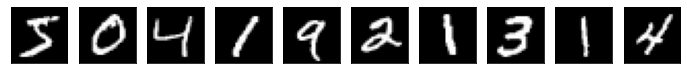

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_digits(data):
    
    if(len(data.shape)==4):
        data = data.squeeze(3)
        
    n, w, h = data.shape
    
    plt.figure(figsize=(12, 12*n))
    for i in range(n):
        ax = plt.subplot(1,n, i+1)
        plt.imshow(data[i], cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
# use the function to plot the first 10 digits (together with the training labels)
plot_digits(x_train[:10, :, :])
print(y_train[:10])

For this first network, we don't care about the structure of the image, so we'll [flatten](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html#numpy.reshape) everything into a 784-dimensional feature vector.

In [ ]:
x_train = x_train.reshape(60000, -1)
x_test = x_test.reshape(10000, -1)

print(x_train.shape) 
print(x_test.shape)

The first model we'll use is a simple fully connected feedforward network. This is called a [Dense layer](https://keras.io/layers/core/#dense) in Keras. Since fully connected layers are a bit heavy on image data (and you're probably running this on your laptop), we'll reduce the dimensionality of the data by PCA (see the [Methodology 2](https://youtu.be/csk2HSWS5r8) lecture).

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=60) # reduce to 60 dimensions
pca.fit(x_train)

x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

print(x_train.shape) 
print(x_test.shape) 

# NB: none of this is Keras yet. We're just using sklearn on some numpy arrays

The training labels are encoded as integers. We need these as one-hot vectors instead, so we can match them to the ten outputs of the neural network.

In [ ]:
from tensorflow.keras.utils import to_categorical

print(y_train.shape, y_test.shape)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(y_train.shape, y_test.shape)

The labels are now encoded as _one-hot vectors_: vectors of length 10 with zeros everywhere, except at the true class.

In [ ]:
print(y_train[0]) # print the one-hot vector for the first example

We are now ready to create a model. Keras has two APIs for this: the **Sequential API** and the **Model API**. The sequential API (the simplest) assumes that your model is a simple sequence of operations, usually neural network layers. The input is passed through the first layer, the result of that is passed through the second and so on. 

Note that it's the _model_ that is sequential, not the data. We are not dealing with sequential data (like language) here.

This is useful for simple NN models where you are only interested in the input and output. If your model gets more complex, you may want to use the Model API (we'll discuss that below).

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(128, input_shape=(60,))) # first dense layer, 32 hidden units
model.add(Activation('relu'))            # activation layer
model.add(Dense(10))                     # second dense layer
model.add(Activation('softmax'))         # output class probabilities

model.summary()

There are a few things to note:

* For the first layer we need to provide the input shape. For the second, this is not necessary, because Keras can _infer_ the input shape from the layers before it.
* The Dense layers are just linear operations (multiply by a weight matrix, add a bias vector). The activation functions are added as separate layers (activation_1, and activation_2). You can also pass the activation as an argument to the Dense layer.
* Keras picks a sensible default weight initialization for us, and applies it (this model already has initial weights).
* The last layer has 10 nodes (one for each class) with a softmax activation. This means we can interpret the output as class probabilities.
* Even though we specified a one-dimensional input, the model summary shows two-dimensional shapes with the first dimension always ```None```. This is the _batch dimension_. Neural networks are almost never trained/run one input at a time; we usually feed them several inputs together (a mini-batch). So, if we choose a batch size of ten, our input dimension would become (10, 60 ) and our first hidden layer would have dimensions (10, 32). Keras can be flexible about the batch size so we don't have to specify it now.



To get a complete computation graph, we need more than just a model: we need a loss function as well. We also need to specify which optimizer we're going to use. 

Let's use categorical cross-entropy as loss, together with the _Adam_ optimizer. All Keras' [optimizers](https://keras.io/optimizers/) are variations on gradient descent. Adam is a good default choice.

With this information, we can compile the model.

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam

optimizer = Adam(lr=0.001) # lr is the learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

We've also told the compiler that we'd like it to compute accuracy for us during training (since categorical cross-entropy is a bit hard to interpret).

We're now ready to start training:

In [ ]:
# Train the model, iterating on the data in batches of 32 samples
model.fit(x_train, y_train, epochs=5, batch_size=32);

On my laptop (no GPU), this takes about 3 to 5 seconds per epoch (an epoch is a pass over the whole data).

Note that these losses/accuracies are on the training data, so we can't tell if we're overfitting. Of course, **we don't want to use the test data at this stage to see how well we're doing**. We can tell Keras to withhold some validation data, so we can get an indication of the accuracy.

In [ ]:
# Train the model, iterating on the data in batches of 32 samples
model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=1/6);

I end up with a validation accuracy of about 96%. Note that the model remembers its weights between cells so we've now trained it for 10 epochs, not 5.

Apparently, kNN with 60 dimensional PCA'd MNIST [can get an accuracy of 97.5%](http://bradleymitchell.me/?p=102), so we're doing ok. Let's see if we can do better with a convolutional neural net.

## A ConvNet for classification

What deep neural networks really excel at, is _making use of all the data_. We've denied our neural network that by reducing the features with PCA. This time, we'll train a network on the complete images, but we'll use a sparsely connected network, a so called convolutional neural net. See the _Deep Learning 1_ lecture for more information.

First, we'll reload the data, to undo our PCA.

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(x_train.shape) 
print(x_test.shape)

This time, we'll _keep the shape_. Keras needs that information to know how to wire up the Convolutional layers.

Keras expects images to be 3-tensors with dimensions width, height, _channels_. Even though our images are grayscale, so have only one channel, the dimension still needs to be there. We'll add a dimension to the test and training data

In [ ]:
x_train = x_train[:, :, :, None]
x_test  = x_test[:, :, :, None]

print(x_train.shape) 
print(x_test.shape)

Here is our network (inspired by [this keras example](https://keras.io/examples/vision/mnist_convnet/)).

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten

model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) # Dropout 25% of the nodes of the previous layer during training
model.add(Flatten())     # Flatten, and add a fully connected layer
model.add(Dense(128, activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax')) # Last layer: 10 class nodes, with dropout
model.summary()

Note that we have about half a million parameters. With a strong optimizer like Adam, and a big dataset like MNIST, this shouldn't be a problem.

In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model, iterating on the data in batches of 32 samples
model.fit(x_train, y_train, epochs=15, batch_size=32, validation_split=1/6)

It's a little slower than the previous network (around 50 seconds per epoch on my machine), but worth waiting for. After just one epoch, the validation accuracy is already ~97%.

## Autoencoders

The real fun of deep learning comes from building things that are not traditional classifiers, but that put the deep learning building blocks to another use. A simple example is an auto-encoder. We only discuss autoencoders in the _Deep Learning 2_ lecture, but the principle is simple: we want the neural network to reconstruct its input, but one of the layers in the middle is very small.

For this, we'll ditch the Sequential API and go for the <em>Model API</em>. It's a little more complex, and a lot more powerful.

First, we'll reload the data again. This time, we need to rescale the pixel values to be between 0 and 1.

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train[:, :, :, None]
x_test  = x_test[:, :, :, None]

x_train = x_train / 255.
x_test = x_test / 255.

Next, we'll build an encoder that maps the data to a small vector of just two dimensions. 

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Reshape, MaxPooling2D, UpSampling2D, Flatten
from tensorflow.keras.models import Model

hidden_size = 2 # very small hidden size for an autoencoder, but it lets us plot the results

input = Input(shape=(28,28,1))

x = Conv2D(4, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1))(input)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (4, 4), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (4, 4), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
x = Dense(hidden_size)(x)

encoder = Model(input, x)

encoder.summary()

The encoder takes the input and transforms it (through some convolutions) to a 2D point. Note that:

* We are building a computation graph before seeing the data: we start with a placeholder (the ```Input```), and apply several transformations to it. At the end, the object ```x``` holds the whole computation graph. We then specify that our model consists of this computation graph, uses the placeholder node ```input``` as its input and uses ```x``` as its output.
* We no longer need to store the sequence of layers. By the end, everything is stored inside x. We can create a layer, apply it and forget about it.

We also define a <em>decoder</em>, which does the opposite: it starts with a 2D point (usually the output of our encoder), and transforms it back to an image.

In [ ]:
encoded = Input(shape=(hidden_size,))

x = Dense(128)(encoded)
x = Reshape((4,4,8))(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(2, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(encoded, decoded)

decoder.summary()

The complete autoencoder now just consists of applying first the encoder model, and then the decoder model.

In [ ]:
auto = Model(input, decoder(encoder(input)))

auto.summary()

Note that we can use models as components in other models: we build the complete autoencoder by combining the encoder and the decoder. The nice thing here is that we can use the model ```auto``` for training, and then use the encoder and decoder separately to play around with the trained model.


We train the autoencoder with binary cross-entropy (each pixel is seen as a probability).

In [ ]:
auto.compile(optimizer='adam', loss='binary_crossentropy')

# This gives depracation warning, ignore that.

To fit the model, we provide it with the training data both as input and output (this is what makes it an autoencoder). This time we're not worried about overfitting, so we don't need a validation set. The better our model reconstructs the data, the happier we are.

In [ ]:
auto.fit(x_train, x_train, epochs=10, batch_size=128)

This takes around one minute per epoch on my machine (so you may want to get a cup of coffee while it runs). If you're in a hurry, the rest of the worksheet also works if you stop it after two epochs.

Let's run some test images through the autoencoder, and see what the reconstructions look like.

In [ ]:
inputs = x_test[:10, :, :, :]
outputs = auto.predict(inputs)

plot_digits(inputs)
plot_digits(outputs)

The reconstructions are far from perfect, but remember that we've reduced the whole image to just two numbers, and then reconstructed it.

Since the latent space of of this autoencoder is 2D, we can plot what the data looks like in 2D.

In [ ]:
num = 5000

inputs = x_test[:num, :, :, :]
latent = encoder.predict(inputs)

plt.scatter(latent[:,0], latent[:,1], c=y_test[:num], alpha=0.1)


We've colored the points by class, but remember that the autoencoder has no access to the class labels. The structure  you see here was learned purely from the pixel values. With more training (and a more powerful model), it's possible to get almost complete separation of the classes.

A final trick we can do with encoder models, is to _interpolate in the latent space_. We pick two encoded examples, draw a line between them, and decode points spaced equally on that line. This will give us a slow tranformation from one example to the other. 

In [ ]:
import numpy as np

# Two random digits, try changing the indices to see what happens
example1 = x_test[190,:,:,:] 
example2 = x_test[237,:,:,:]

l1, l2 = encoder.predict(example1[None, :,:,:]), encoder.predict(example2[None, :,:,:])
#-- we add the None, because keras expects a batch dimension (even if the batch size is 1)

# ten points, equally spaced between 0 and 1
line = np.linspace(0, 1, 10)[:, None]

points = l1 * line + l2 * (1-line)

# Plot the points we will decode
plt.scatter(latent[:,0], latent[:,1], c=y_test[:num], alpha=0.01)
plt.scatter(points[:, 0], points[:, 1])

outputs = decoder.predict(points)
plot_digits(outputs.squeeze(3))

This may not yet look very convincing if you stoppped training early.

It works best if the decoding looks good (which is difficult to achieve with this model, relatively little training, and a 2D latent space). 

Try setting the latent space higher: increase ```hidden_size``` above  to something like 64. Rebuild the model and rerun the experiment. The plots above will still work, but they will only show the first two dimensions of a 64-dimensional latent space.

## Final comments

As before, we have given you hopefully just enough to get you started, but there is much more to learn. This means that once you start trying things, you will almost certainly get stuck. Feel free to ask questions on the discussion board, we'll do our best to help. 

Some recommendations:
* Plot your [loss curves](). We recommend using Tensorboard to monitor your training, which integrates well with Keras.
* The most important hyperparameters to tweak are probably _batch size_, _learning rate_ and _number of hidden units_.
* It's likely that at some point [your loss function will suddenly become NaN](http://russellsstewart.com/notes/0.html) (not a number). This often happens when one of the units somewhere in your network gets very big (close to infinite). This causes the loss to become infinite for, which gives NaN for the gradient. Keras still continues with the backpropagation, and the whole network becomes NaN. Usually, it help to reduce the learning rate or to increase the number of hidden units. If not, you should train your model one batch at a time by calling model.train_on_batch(), printing the weights after each batch. This allows you to see what happens just before the loss becomes NaN, which may give you a hint as to what is happening.
* As you can see, even training a medium-size network can take a long time, especially if you don't have access to a GPU. One trick you can try is [transfer learning](https://towardsdatascience.com/transfer-learning-using-keras-d804b2e04ef8). Using a model that somebody else has trained, and building on top of it. This allows you to use the power of a deep network, while only training a few layers yourself. The VGG network, which Keras can download for you, is a particularly good choice.
* If you want to compare Keras models against other classifiers or regression methods, Keras [integrates with sklearn](https://keras.io/scikit-learn-api/).
* For modest networks, you should be able to just let your laptop run overnight to perform experiments. If you want a little more power, you'll need a GPU.
 * [Google Colab](https://colab.research.google.com) is a cloud-based notebook environment based on Jupyter. It's easy to request a GPU and run your notebook based experiments in there,
 * Google Cloud Compute has [a 300$ free tier](https://hackernoon.com/launch-a-gpu-backed-google-compute-engine-instance-and-setup-tensorflow-keras-and-jupyter-902369ed5272), that should be enough to run experiments for this course (especially if everybody n your group signs up). Making mistakes in cloud computing can be costly, so be sure to do the following:
 * Make sure the machine turns off after each experiment.
 * Set up budget limits and alerts so you realize quickly if you're running our of credit.
 * Keep your private key and signup email _extremely_ private. If, for instance, you accidentally put this on github, it will get crawled almost immediately and someone will set up a bitcoin miner on your credit.

Here are some good resources to read first:
* [37 reasons why your neural network is not working](https://blog.slavv.com/37-reasons-why-your-neural-network-is-not-working-4020854bd607)
* [25 Must Know Terms & concepts for Beginners in Deep Learning](https://www.analyticsvidhya.com/blog/2017/05/25-must-know-terms-concepts-for-beginners-in-deep-learning/)
* [Directory of Keras tutorials and other resources](https://github.com/fchollet/keras-resources)
* [CS231n](http://cs231n.stanford.edu/) A famous Stanford course on computer vision with deep neural networks. The level is a little higher than our course, but they also deal with the practicalities of deep learning a lot better.
* [DLVU](https://dlvu.github.io) Our own deep learning course. It's an MSc course, so the level is a little higher, but the first few lectures shouldn't be too difficult too follow, and they'll give you a lot more detail.

Happy Learning!
